In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
1+1


In [1]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN

fatal: destination path 'PyTorch-GAN' already exists and is not an empty directory.


In [2]:
%cd PyTorch-GAN

/content/PyTorch-GAN


In [3]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.3Gi       3.2Gi       1.0Mi       8.2Gi        11Gi
Swap:             0B          0B          0B


In [4]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   34G   79G  31% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
/dev/sda1        92G   64G   28G  70% /kaggle/input
tmpfs           6.4G  436K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [5]:
!ls

assets	data  implementations  LICENSE	README.md  requirements.txt


In [6]:
pip install -r requirements.txt

In [7]:
%cd implementations/acgan

/content/PyTorch-GAN/implementations/acgan


In [16]:
def poison_dataset(dataset, poison_ratio=0.2):
    """
    Function to poison the dataset by changing a percentage of random samples
    to have a random label.

    Args:
        dataset: The dataset to be poisoned (assumed to be torchvision dataset).
        poison_ratio: The ratio of samples that should have a randomly changed label.

    Returns:
        poisoned_dataset: The poisoned version of the dataset.
    """
    num_samples = len(dataset)
    num_poisoned_samples = int(num_samples * poison_ratio)
    poisoned_indices = np.random.choice(num_samples, num_poisoned_samples, replace=False)

    poisoned_dataset = []
    for i in range(num_samples):
        img, label = dataset[i]
        if i in poisoned_indices:
            label = np.random.choice([l for l in range(100) if l != label])  # Avoid keeping the same label
        poisoned_dataset.append((img, label))

    return poisoned_dataset


In [24]:
# Original code imports remain the same
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch

# Create the images directory
os.makedirs("images", exist_ok=True)

# Argument parser setup
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=100, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=16, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=100, help="number of classes for CIFAR-100")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels (CIFAR-100 is RGB)")
parser.add_argument("--sample_interval", type=int, default=200, help="interval between image sampling")
opt = parser.parse_args([])  # No command-line arguments passed
print(opt)

cuda = True if torch.cuda.is_available() else False

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# Generator definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)
        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Discriminator definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity, label

# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader for CIFAR-100
os.makedirs("../../data/cifar100", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR100(
        root="../../data/cifar100",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(opt.img_size),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)



Namespace(n_epochs=100, batch_size=256, lr=0.0002, b1=0.5, b2=0.999, n_cpu=16, latent_dim=100, n_classes=100, img_size=32, channels=3, sample_interval=200)
Files already downloaded and verified


for gaussian noise

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

# Load CIFAR-100 dataset
transform = transforms.ToTensor()
cifar100_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, max_std=0.5):
    std = random.uniform(0, max_std)  # Random std in range [0, max_std]
    noise = torch.randn(image.size()) * std + mean  # Generate Gaussian noise
    noisy_image = image + noise  # Add noise to the original image
    return torch.clamp(noisy_image, 0., 1.)  # Clamp to ensure pixel values stay in [0, 1]

# Add Gaussian noise to 30% of the CIFAR-10 dataset
num_noisy_samples = int(0.3 * len(cifar100_data))  # 30% of the dataset
random_indices = np.random.choice(len(cifar100_data), num_noisy_samples, replace=False)

# Create a modified dataset with noise added to some images
modified_images = []
for idx in range(len(cifar100_data)):
    image, label = cifar100_data[idx]
    if idx in random_indices:
        image = add_gaussian_noise(image)  # Add noise to 10% of the images
    modified_images.append((image, label))

# Create a DataLoader for the modified dataset
modified_dataset = TensorDataset(
    torch.stack([img for img, _ in modified_images]),
    torch.tensor([lbl for _, lbl in modified_images])
)

Files already downloaded and verified


for compound

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

# Load CIFAR-100 dataset
transform = transforms.ToTensor()
cifar100_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, max_std=0.5):
    std = random.uniform(0, max_std)  # Random std in range [0, max_std]
    noise = torch.randn(image.size()) * std + mean  # Generate Gaussian noise
    noisy_image = image + noise  # Add noise to the original image
    return torch.clamp(noisy_image, 0., 1.)  # Clamp to ensure pixel values stay in [0, 1]

# Add Gaussian noise to 30% of the CIFAR-10 dataset
num_noisy_samples = int(0 * len(cifar100_data))  # 30% of the dataset
random_indices = np.random.choice(len(cifar100_data), num_noisy_samples, replace=False)

# Create a modified dataset with noise added to some images
modified_images = []
for idx in range(len(cifar100_data)):
    image, label = cifar100_data[idx]
    if idx in random_indices:
        image = add_gaussian_noise(image)  # Add noise to 10% of the images
    modified_images.append((image, label))

# Apply label flipping attack to the noisy dataset
poisoned_dataset = poison_dataset(modified_images, poison_ratio=0.2)

# Create a DataLoader for the modified dataset
modified_dataset = TensorDataset(
    torch.stack([img for img, _ in modified_images]),
    torch.tensor([lbl for _, lbl in modified_images])
)

Files already downloaded and verified


For Outliers

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

# Load CIFAR-100 dataset
transform = transforms.ToTensor()
cifar100_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

class OutlierInjectedCIFAR(torch.utils.data.Dataset):
    def __init__(self, dataset, outlier_fraction=0.2):
        """
        Outlier injection attack by replacing a fraction of CIFAR-10 images with random noise.

        Args:
            dataset: Original CIFAR-10 dataset.
            outlier_fraction: Fraction of dataset to replace with random noise (default: 20%).
        """
        self.dataset = dataset
        self.outlier_fraction = outlier_fraction
        self.outlier_indices = set()
        self.inject_outliers()

    def inject_outliers(self):
        """Injects random noise images as outliers into the dataset."""
        num_outliers = int(self.outlier_fraction * len(self.dataset))
        outlier_indices = np.random.choice(len(self.dataset), num_outliers, replace=False)
        self.outlier_indices = set(outlier_indices)

        for idx in outlier_indices:
            # Generate a completely random noise image
            random_image = torch.randn((3, 32, 32))  # CIFAR-10 has 3 channels, 32x32 size

            # Assign a random label (not necessarily related to real classes)
            random_label = np.random.randint(0, 10)

            # Replace original sample with outlier
            self.dataset.data[idx] = (random_image.permute(1, 2, 0) * 255).byte().numpy()
            self.dataset.targets[idx] = random_label

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# Apply outlier injection attack (e.g., 20% of images replaced with random noise)
poisoned_dataset = OutlierInjectedCIFAR(cifar100_data, outlier_fraction=0.2)

# Convert to TensorDataset for DataLoader
final_dataset = TensorDataset(
    torch.tensor(poisoned_dataset.dataset.data).permute(0, 3, 1, 2).float() / 255,
    torch.tensor(poisoned_dataset.dataset.targets)
)

dataloader_outlier = DataLoader(final_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)


Files already downloaded and verified


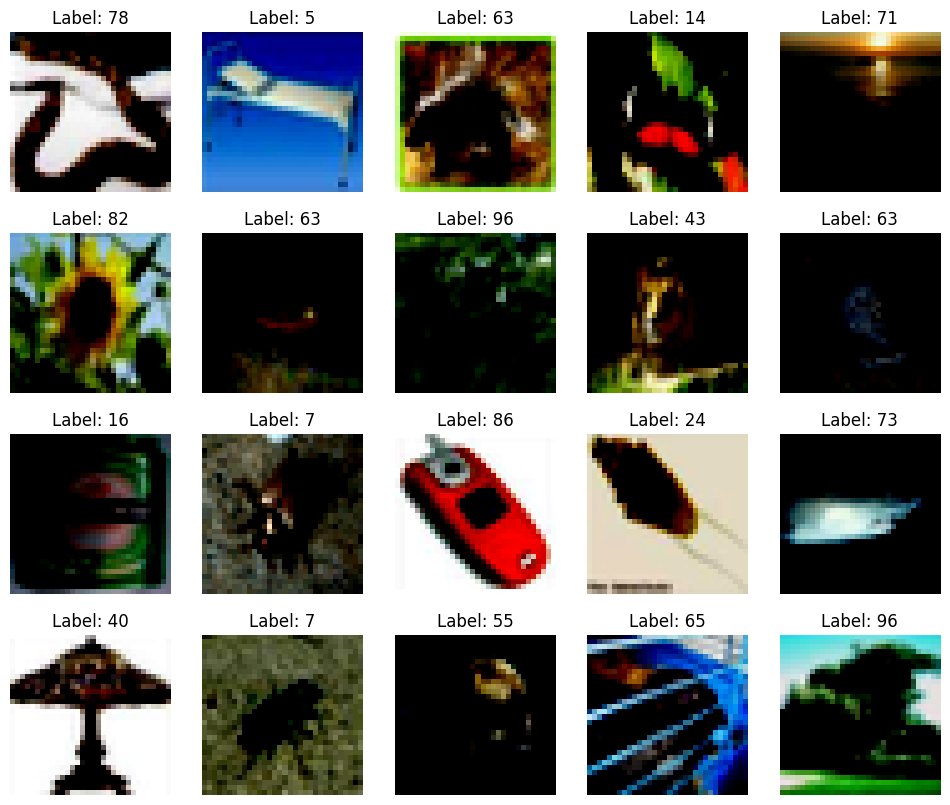

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


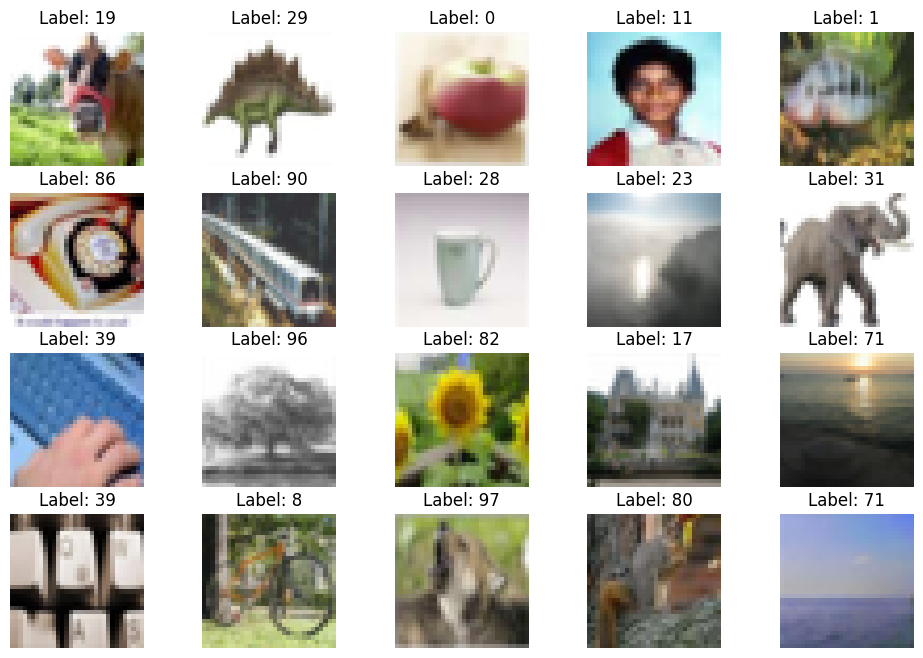

In [30]:
dataiter = iter(dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    image = images[i]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')
plt.show()

dataloader = DataLoader(modified_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
# Plot some noisy and non-noisy images for verification
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    image, label = modified_images[i]
    ax.imshow(image.permute(1, 2, 0).numpy())  # Convert tensor to NumPy array and rearrange dimensions
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.show()


In [31]:

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def sample_image(n_row, batches_done):
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

# Training loop
for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.shape[0]
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # Train Generator
        optimizer_G.zero_grad()
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))
        gen_imgs = generator(z, gen_labels)
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        d_loss = (d_real_loss + d_fake_loss) / 2

        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Streaming output truncated to the last 5000 lines.
[Epoch 74/100] [Batch 96/196] [D loss: 2.577300, acc: 15%] [G loss: 2.575444]
[Epoch 74/100] [Batch 97/196] [D loss: 2.566382, acc: 16%] [G loss: 2.584793]
[Epoch 74/100] [Batch 98/196] [D loss: 2.558844, acc: 18%] [G loss: 2.590191]
[Epoch 74/100] [Batch 99/196] [D loss: 2.550963, acc: 19%] [G loss: 2.520290]
[Epoch 74/100] [Batch 100/196] [D loss: 2.550635, acc: 19%] [G loss: 2.532917]
[Epoch 74/100] [Batch 101/196] [D loss: 2.568228, acc: 16%] [G loss: 2.598230]
[Epoch 74/100] [Batch 102/196] [D loss: 2.566723, acc: 18%] [G loss: 2.537841]
[Epoch 74/100] [Batch 103/196] [D loss: 2.561511, acc: 19%] [G loss: 2.482952]
[Epoch 74/100] [Batch 104/196] [D loss: 2.579641, acc: 16%] [G loss: 2.540547]
[Epoch 74/100] [Batch 105/196] [D loss: 2.573262, acc: 19%] [G loss: 2.518456]
[Epoch 74/100] [Batch 106/196] [D loss: 2.557921, acc: 20%] [G loss: 2.494757]
[Epoch 74/100] [Batch 107/196] [D loss: 2.564803, acc: 18%] [G loss: 2.508945]
[Epoc

In [32]:
generator.eval()  # Set to evaluation mode
discriminator.eval()

test_dataset = datasets.CIFAR100(
    "../../data/cifar100",
    train=False,  # Set train=False to load the test dataset
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)


# Create the test DataLoader
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=opt.batch_size,
    shuffle=False,  # No need to shuffle the test dataset
)

all_preds = []
all_labels = []
all_validities = []

with torch.no_grad():  # Disable gradient computation for faster performance
    for imgs, labels in test_dataloader:
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # Generate predictions from discriminator
        validity, pred_labels = discriminator(real_imgs)

        # Save predictions and actual labels for evaluation
        all_preds.append(pred_labels.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_validities.append(validity.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_validities = np.concatenate(all_validities, axis=0)


# Calculate accuracy
pred_classes = np.argmax(all_preds, axis=1)
accuracy = np.mean(pred_classes == all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Files already downloaded and verified
Test Accuracy: 1.59%


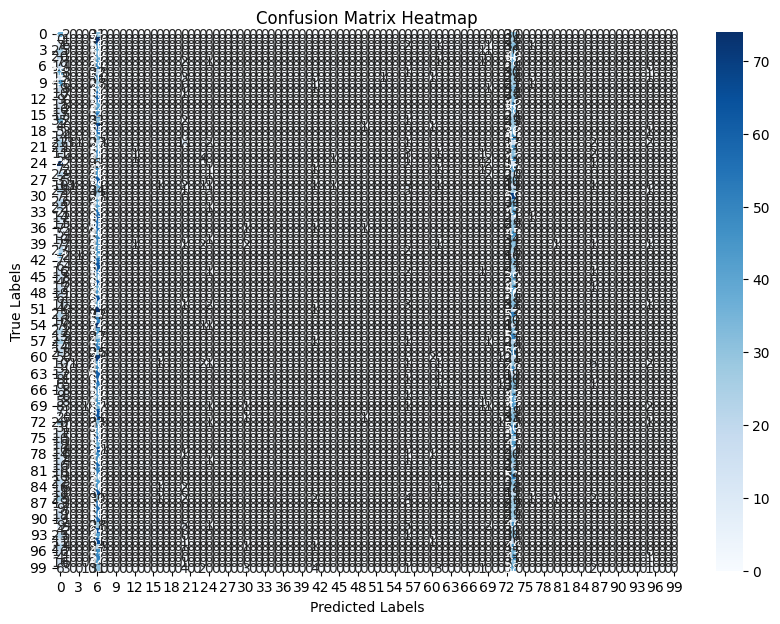

In [33]:
#For Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_mat = confusion_matrix(all_labels, pred_classes)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


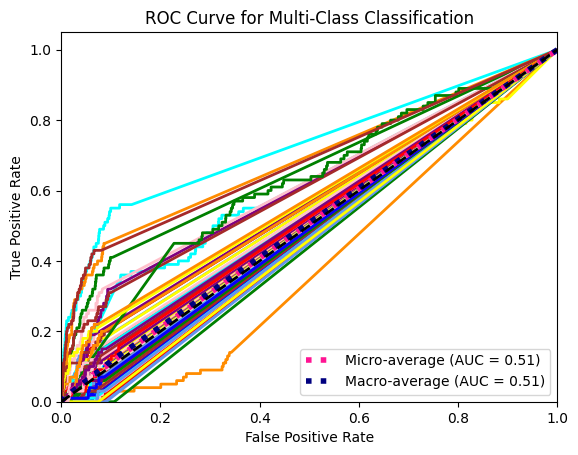

Micro-average AUC: 0.5063
Macro-average AUC: 0.5078


In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC curve calculation
n_classes = opt.n_classes
labels_binarized = label_binarize(all_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(labels_binarized.ravel(), all_preds.ravel())
micro_auc = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Plot ROC curve for each class
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "purple", "red", "yellow", "blue", "pink", "brown"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2)

# Plot micro and macro average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4, label=f'Micro-average (AUC = {micro_auc:.2f})')
plt.plot(all_fpr, mean_tpr, color='navy', linestyle=':', linewidth=4, label=f'Macro-average (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()

print(f"Micro-average AUC: {micro_auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")


<ipython-input-35-0d1a5b2941b1>:52: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


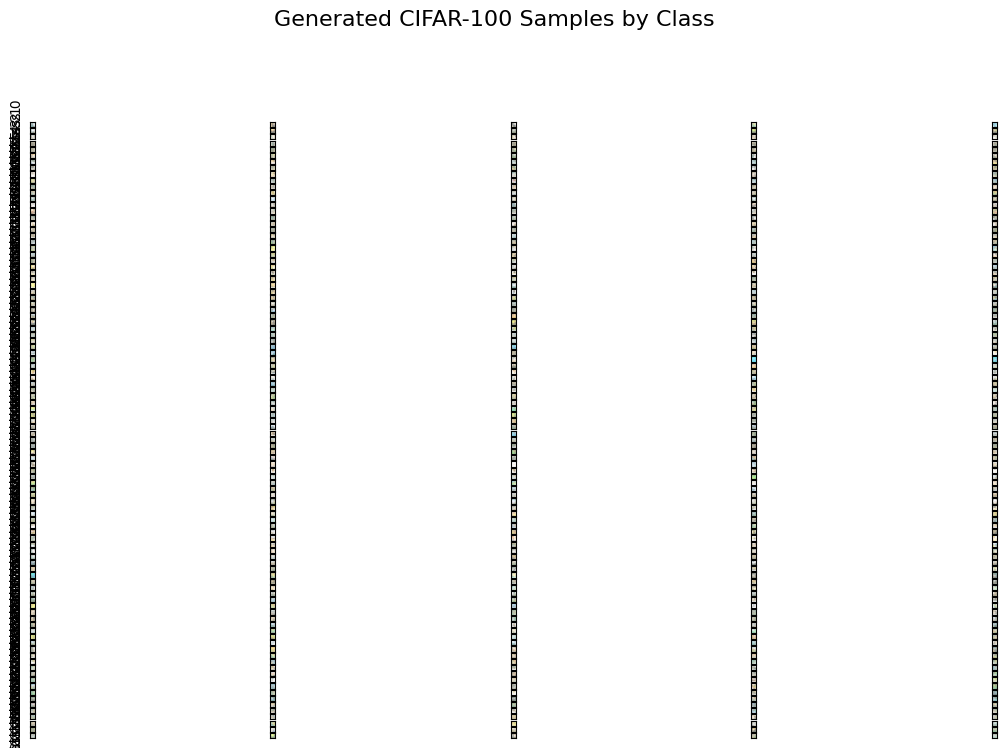

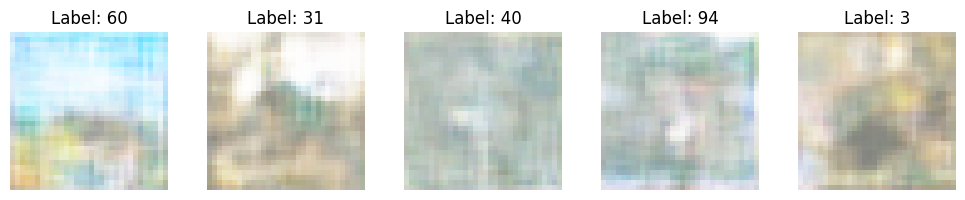

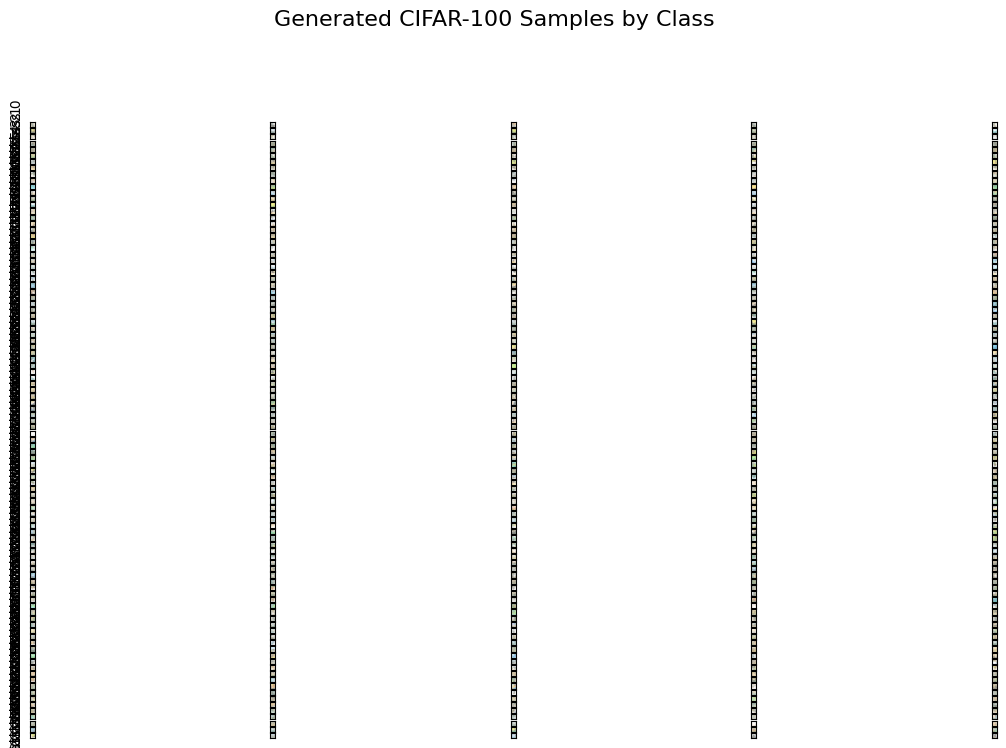

Predicted Labels by Discriminator:
[41 41 20 23 20 61 23 61 61 23 23 23 23 61 23 41 23 41 23 24 44 23 23 69
 44 23 86  5 86  5 61 20 20 20 20 20 20 24 20 20 86 20 61 23 61 23 61 20
 20 61 69 23 23 20 86 69 61 23 23 23 86 12 61 86 12 61 61 23 23 86 20 20
 20 61 20 23 86 61 61 71 16 16 16 23 16 71 71 17 24 61 20 20 86 86 24 23
 61 61 23 61 20 20 20 20 20 17 23 86 61 23 23 23 20 61 69 23 23 23 23 23
 24 24 24 20 24 23 23 23 61 23 23 23 23 23 86 20 23 20 20 20 23 86 71 86
 61 61 23 23 23 71 23 61 86 23 23  5 61 24 24 23 23 23 86 61 61 23 23 23
 23 86 23 23 23 23 23 61 61 23 61 61 71 23 20 23 23 23 61 23 20 61 23 20
 20 20 23 23 61 61 23 23 20 16 23 20 23 23 41 41 41 41 23 61 23 86 71 61
 61 61 16 23 23 23 23 23 23 61 20 23 23 20 71 20 23 23 86 23 86 23 61 41
 61 61 20 20 20 23 71  5 86 23 20 23  5 23 41 23 23 23 20 41 86 86 86 20
 86 71 86 23 86 61 86 61 23 23 20 61 23 69 61 24 16 20 86 61 69 23 20 23
 20 20 20 20 20 20 61 20 23 86 86 20 60 60 60 60 60 61 61 61 61 61 61 61
 61 20 20 61 86 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def generate_and_display_samples(generator, num_samples=5, latent_dim=100, num_classes=100):
    """
    Generate and display samples from the conditional CIFAR-100 generator.

    Parameters:
    - generator: Trained generator model
    - num_samples: Number of samples to generate per class
    - latent_dim: Dimension of the latent noise vector
    - num_classes: Number of classes (10 for CIFAR-10)
    """
    # Set up the figure
    fig = plt.figure(figsize=(15, 8))
    total_samples = num_samples * num_classes

    # Set generator to evaluation mode
    generator.eval()

    # Get the device that the generator is on
    device = next(generator.parameters()).device

    # Generate samples for each class
    with torch.no_grad():
        # Create noise and labels
        z = torch.randn(total_samples, latent_dim, device=device)
        labels = torch.tensor(
            [i for i in range(num_classes) for _ in range(num_samples)],
            device=device
        )

        # Generate images
        generated_images = generator(z, labels)

        # Convert to numpy and scale to [0, 1]
        generated_images = (generated_images.cpu().numpy() * 0.5 + 0.5).transpose(0, 2, 3, 1)  # (N, C, H, W) → (N, H, W, C)

    # Display images
    for idx, img in enumerate(generated_images):
        ax = fig.add_subplot(num_classes, num_samples, idx + 1)
        plt.imshow(img)  # CIFAR-10 images are in RGB
        ax.set_xticks([])
        ax.set_yticks([])

        # Add label on first column
        if idx % num_samples == 0:
            ax.set_ylabel(f'Class {idx // num_samples}', fontsize=10)

    plt.suptitle('Generated CIFAR-100 Samples by Class', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    return generated_images, labels

def generate_specific_samples(generator, specific_labels, latent_dim=100):
    """
    Generate samples for specific labels in CIFAR-100.

    Parameters:
    - generator: Trained generator model
    - specific_labels: List of labels to generate samples for
    - latent_dim: Dimension of the latent noise vector
    """
    generator.eval()
    device = next(generator.parameters()).device
    num_samples = len(specific_labels)

    plt.figure(figsize=(num_samples * 2, 2))

    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        labels = torch.tensor(specific_labels, device=device)

        generated_images = generator(z, labels)
        generated_images = (generated_images.cpu().numpy() * 0.5 + 0.5).transpose(0, 2, 3, 1)

    for idx, (img, label) in enumerate(zip(generated_images, specific_labels)):
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return generated_images, labels

def test_discriminator_on_generated(discriminator, generator, num_samples=5, latent_dim=100, num_classes=100):
    """
    Generate samples using the generator and classify them using the discriminator.

    Parameters:
    - discriminator: Trained discriminator model
    - generator: Trained generator model
    - num_samples: Number of samples to generate per class
    - latent_dim: Dimension of the latent noise vector
    - num_classes: Number of classes
    """
    generated_images, labels = generate_and_display_samples(generator, num_samples, latent_dim, num_classes)

    # Convert generated images to tensors
    generated_images = torch.tensor(generated_images, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (N, C, H, W)

    device = next(discriminator.parameters()).device
    generated_images = generated_images.to(device)

    discriminator.eval()
    with torch.no_grad():
        _, predicted_labels = discriminator(generated_images)
        predicted_classes = torch.argmax(predicted_labels, dim=1).cpu().numpy()

    print("Predicted Labels by Discriminator:")
    print(predicted_classes)

# Example usage:
if __name__ == "__main__":
    # Generate samples for all classes
    generate_and_display_samples(generator, num_samples=5)

    # Generate specific samples
    specific_labels = [60, 31, 40, 94, 3]  # Generate these specific classes
    generate_specific_samples(generator, specific_labels)

    # Test discriminator on generated images
    test_discriminator_on_generated(discriminator, generator, num_samples=5)
